# Applied Criptography - Laboratory #3 - Extra #2

## Q1: Weak Security
### Question - P1

For this question, see the code in the file **q1.py**

### Question - P2
We first need to know how much guesses, in average, does my device make per second.

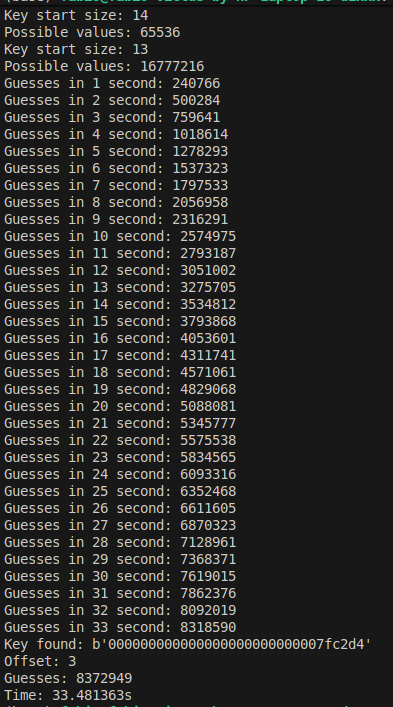

|Interval (s) |	Guesses per Second |
|:-----------:|:------------------:|
|0-1	|259518
|1-2	|259357
|2-3	|258973
|3-4	|259679
|4-5	|259030
|5-6	|260210
|6-7	|259425
|7-8	|259333
|8-9	|258684
|9-10	|218212
|10-11	|257815
|11-12	|224703
|12-13	|259107
|13-14	|259056
|14-15	|259733
|15-16	|258140
|16-17	|259320
|17-18	|258007
|18-19	|259013
|19-20	|257696
|20-21	|229761
|21-22	|259027
|22-23	|258751
|23-24	|259152
|24-25	|259137
|25-26	|258718
|26-27	|258638
|27-28	|239410
|28-29	|250644
|29-30	|243361
|30-31	|229643
|31-32	|226571


Note: Each time is used "." for numbers from now on, it does NOT mean the decimal point, but the separator for thousands so the values are more readable.

We can appreciate in this table the amount of guesses produced by my computer in **Python** in the period of 1 second. The average is **252.078,48** which will be round to **252.078**.

In 3 hours there are 60 minutes, in each minute there are 60 seconds. So we can calculate the amount of second in 3 hours, which would be 3*60*60 = 10.800 seconds.

So, for my machine to reach the 3 hours limit, it needs to atleast guess 10.800 * 252.078 = 2.722.442.400 times. This means, we need to find an offset that reached at least that quantity of possible values for the key.

For an offset of length N, the possible values for the key would be:

$$
\sum_{i = 1}^{N} 256^i
$$

In [2]:
def sum_possible_values(n: int) -> int:
    total:int  = 0
    for i in range(1, n + 1):
        total += 256**i
    return total

for key_length in range(1, 6):
    print(f"Total possible value for offset length {key_length}: {sum_possible_values(key_length)}")

Total possible value for offset length 1: 256
Total possible value for offset length 2: 65792
Total possible value for offset length 3: 16843008
Total possible value for offset length 4: 4311810304
Total possible value for offset length 5: 1103823438080


We can see that just with an offset of length 4 we reach (and even almost double) the necessary amount of values for the machine to last 3 hours.


## Q2: Fixed Initialization Vectors

Beforehand, it's important to mention that AES block cipher encruption is a deterministic function. For the same plaintext it always returns the same ciphertext. The randomness given by the iv is what makes it random. 

In this case, since the iv is always the same, whatever the plaintext is, we can assume that for every plaintext blocks Pn and Pm and their correspondents ciphertext blocks Cn and Cm, if Pn = Pm, then Cn = Cm.

So, this makes easy to break the experiment.

- We first will query Enc(k, m). It can be any m at this point
- We then will send m (the same one used for the previous query) and another arbitrary message.
- Then, assuming we know the respective b for the message m, we just check the ciphertext given by the challenger. If it exactly the same as the ciphertext we queried at the beginning, then we know b' is b, if not, then b' is the opposite value of b. 

An example is, if m is m0, then if the ciphertext given by the challenger is the same as the one we requested, b = 0, if not, then b = 1.

## Q3: Predictable Initialization Vectors

### Question - P1

First of all. We'll make an analysis of what happens if we encrypt 0^l with 0^l as the Nonce using this cipher scheme.

Let's assume that our message M has three block so M = 0 || 0 || 0 (each zero block is 128 bits).

IV = Ec(k, n) -> IV = Ec(k, 0)
C1 = Ec(k, m, n) -> 
C1 = Ec(k, Ec(k, n) XOR 0) -> 
C1 = Ec(k, Ec(k, 0) XOR 0) ->     (a XOR 0 = a)
C1 = Ec(k, Ec(k, 0))  

Then the second block C2

C2 = Ec(k, C1 XOR 0) ->
C2 = Ec(k, C1) ->

Then and at last block C3

C3 = Ec(k, C2 XOR 0) ->
C3 = Ec(k, C2) ->


We can get all this information just with the initial request.

Now, we can start the challenge. Firstly, the new nonce we'll choose is C1, it has never been used so it is a valid one. Secondly, the two messages that we'll send are the following:

- m0 = 0||0||0|| (The same as the message we encrypted at the begining)
- m1 = p||0||0|| (With p such as any value that p != 0, i.e., a not null value)

With this options, IV = Ec(k, C1) -> IV = C2
and the first block cipher of the first encrypted message (let's call it C1') would be 

C1' = Enc(k, IV XOR 0) ->
C1' = Enc(k, IV) ->
C1' = Enc(K, C2) ->
C1' = C3


Having all those in mind, the logarithm for chossing either b' would be as the following:

- If the encrypted message has its first block so C1' = C3, choose b' = 0
- Otherwise, choose b' = 1     

This will bring a 100% chance of winning the challenge.


### Question - P2


For this question, the code is in the file **q3p2.py**

In [ ]:
import q3p2 as experiment

trials = 3

experiment.run_experiment(trials)

## Q4: Padding Attacks

### Question - P1

It is necessary adding padding because of how PKCS#7 works. It works in some way so the decryption process is not an ambiguous.

PKCS#7 guarantees to take the last block, read the last byte l of it (1 <= l <= block_size), verify if each of the last l bytes have the value l itself. If they do, remove them.

If the message had a size multiple of b without adding anything at the end, the last byte could have seemed a "padding" value and would have created ambiguity.

That's why it is always added an entire extra block in those cases.

### Question - P2

In CBC, the decryption of a block Ci gives us Pi = Dk(Ci) XOR Ci-i.
A padding oracle returns "padding error" and "valid padding". An attacker can alter bytes of Ci-1 to "force" padding values for the Pi block. It is possivel to retrieve from byte to byte Dk(Ci), with it, we can retrieve Pi.


Let's define X = Dk(C2), then:

P2 = X XOR C1

If we attack the last byte (position 16) and substitute C1[16] with C1'[16], then the last byte of P2' will be

P2'[16] = X[16] XOR C1'[16]

We want to "force" a valid padding, for exemplo, **0x01** (last byte = 1). The oracle will return "valid padding" if P2' ends with **0x01** (or any other valid padding). This way, if the oracle returns "valid padding" we know:

X[16] XOR C1'[16] = 0x01   =>  X[16] = C1'[16] XOR 0x01

Due to the attacker knowing the original C1[16], he then can obtain the last byte of the original plainetext:

P2[16] = X[16] XOR C1[16] = (C1'[16] XOR 0x01) XOR C1[16]


Let's make a numerical example for this, let's assume the following:

- C1[16] (original byte from previous block) = 0xAA
- The attacker tries different modifications. Let's assume that when testing C1'[16] = 0xC3 the oracle accepts the padding (valid padding 0x01)

Then:

1. X[16] = C'[16] XOR 0x01 = 0xC3 XOR 0x01 = 0xC2
2. P2[16] = X[16] XOR C1[16] = 0xC2 XOR 0xAA = 0x68
